# SOM Regression zur Inversen Kinematic

Dieses Notebook implementiert einen Ansatz zur Inversen Kinematic von Manipulatoren anhand einer MultiOutput Regression mit Self-Organizing-Maps. Zur Umsetzung wird das Susi-Framework genutzt, das Verfahren wird gründlich in diesem und den dort verlinkten Papern beschrieben: [SuSi: Supervised Self-Organizing Maps for Regression and Classification in Python](https://arxiv.org/pdf/1903.11114.pdf)

## Kurzgesagt

Susi nutzt zwei SOMs zur Regression. Das erste SOM clustert die Inputvariable und bestimmt die BMU. Das zweite SOM ist identisch von der Anzahl der Neuronen. Die Gewichte des zweiten SOMs werden allerdings als Output für die Regression trainiert. Die vorher durch das unsupervised bestimmte BMU wird im zweiten SOM auf die Groundtruth-Daten trainiert.

<img src="https://www.researchgate.net/profile/Felix-Riese/publication/332034881/figure/fig1/AS:741272549588992@1553744556231/Flowchart-of-the-unsupervised-SOM-algorithm-resulting-in-the-trained-unsupervised-SOM.png" alt="drawing" width="400"/>

Zur Generierung der Daten für den Youbot erstellen wir einen Datahandler für einen Youbotroboter und stellen die Berechnung der Extrempositionen auf `True`. Das bewirkt, dass bei der Generierung des Datensatzes die Extrema der Winkelpositionen für die einzelnen Gelenke ausgewählt werden und so ein möglichst großer Bereich des Raumes, den der Roboter erreichen kann, generiert wird.

In [2]:
from src.robot import Robot
from src.datahandler import DataHandler
import numpy as np

datahandler = DataHandler(robot=Robot(robot='youbot'), euler=True)
datahandler.compute_extreme_positions = True
positions, tcp = datahandler(1024)

Als nächstes importieren wir die für die Regression benötigten Module.

In [3]:
import susi
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

ModuleNotFoundError: No module named 'susi'

Das Susi Framework hat einen SOMRegressor. Hier kann die Anzahl der Neuronen über `n_rows` und `n_cols` gesteuert werden und die Anzahl der Iterationen der beiden SOMs gesteuert werden. In der [Dokumentation](https://susi.readthedocs.io/en/latest/SOMRegressor.html) gibt es eine genaue Aufschlüsselung der Parameter. Der Estimator kann im Anschluss mit einen MultiOutputRegressor aus Scikit-Learn trainiert werden.

In [155]:
som = susi.SOMRegressor(
    n_rows=500,
    n_columns=500,
    n_iter_unsupervised=3000,
    n_iter_supervised=50000,
    n_jobs=12,
    train_mode_unsupervised='online')

mor = MultiOutputRegressor(estimator=som, n_jobs=12)

Ein zuvor abgespeicherter Regressor kann so geladen werden:
```python
import pickle

with open("multioutputregressor.obj", 'rb') as f:
    mor = pickle.load(f)
```

Standardisieren Sie die Eingangsvariablen, indem Sie den Mittelwert entfernen und die Varianz auf eine Einheit skalieren.

In [5]:
# Standardize the data
scaler = StandardScaler()
scaler.fit(tcp)
tcp = scaler.transform(tcp)

Über die `fit` Methode kann der Regressor trainiert werden.

In [157]:
mor.fit(tcp, positions)

MultiOutputRegressor(estimator=SOMRegressor(n_columns=500,
                                            n_iter_supervised=50000,
                                            n_iter_unsupervised=3000, n_jobs=12,
                                            n_rows=500),
                     n_jobs=12)

Zur Generierung von Testdaten muss die Generierung von Extremwerten wieder ausgestellt werden und die Eingangswerte müssen standardisiert werden.

In [10]:
datahandler.compute_extreme_positions = False
positions_test, tcp_test = datahandler(1024)
scaler = StandardScaler()
scaler.fit(tcp_test)
tcp_test = scaler.transform(tcp_test)

Datengenerierung: 0.00 Sekunden
DH Transformation: 0.10 Sekunden
Euler Winkel: 0.03 Sekunden
Normalisierung: 0.00 Sekunden
Gesamt:  0.14 Sekunden


Über die `predict` Methode sollten die TCP Werte durch den Regressor die Gelenkwinkelpositionen vorhersagen können.

In [11]:
y_pred_test = mor.predict(tcp_test)
y_pred_train = mor.predict(tcp)

Was aber nicht so gut funktioniert, wie Sie sehen können:

In [44]:
print("Train: {0:.1f} %".format(r2_score(positions, y_pred_train)*100))
print("Test: {0:.1f} %".format(r2_score(positions_test, y_pred_test)*100))

Train: 28.4 %
Test: -15.6 %


Speichern Sie den Regressor ab, wenn Sie wollen:

In [181]:
import pickle

with open("multioutputregressor.obj", "wb") as f:
    pickle.dump(mor, f)

Wie gewohnt können Sie sich die Ergebnisse mit matplotlib über die RobotAnimation anzeigen lassen.

### Regression auf dem Trainingsdatensatz

<IPython.core.display.Javascript object>


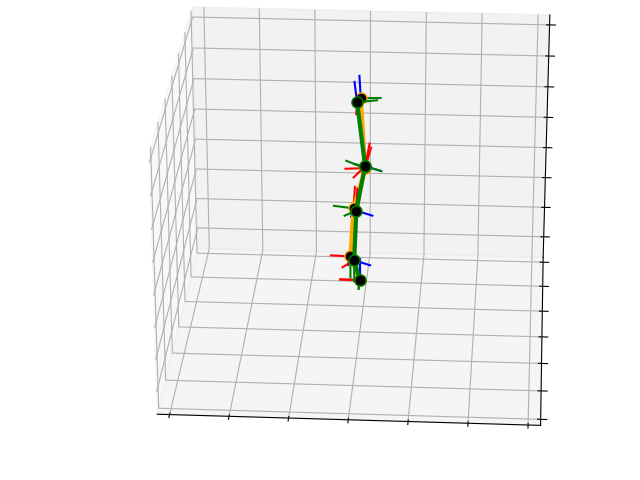

In [53]:
%matplotlib widget

from src.robot_animation import RobotAnimation

i = np.random.randint(0, len(positions))
ani = RobotAnimation(robot=Robot(robot='youbot'))
q_arrays = [y_pred_train[i], positions[i]]
ani.draw_robot(q_arrays)

### Regression auf dem Testdatensatz

<IPython.core.display.Javascript object>


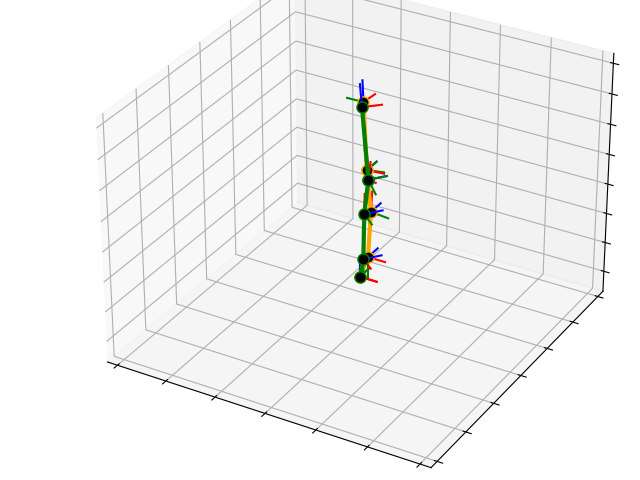

In [49]:
%matplotlib widget

from src.robot_animation import RobotAnimation

ani = RobotAnimation(robot=Robot(robot='youbot'))
q_arrays = [y_pred_test[i], positions_test[i]]
ani.draw_robot(q_arrays)
i = i +1

Erstellung einer Trajektorie zur Überprüfung des Outputs.

In [18]:
start = np.array([169, 0, -20, -30, 0])

y_qarr = []
y_qarr.append(start)
for i in range(26):
    start = np.copy(start)
    if(start[0]-13)>=datahandler.robot.joint_limits[0][1]:
        start[0] += -13
    y_qarr.append(start)

y_qarr = np.radians(np.asarray(y_qarr))

So sollte es aussehen:

<IPython.core.display.Javascript object>


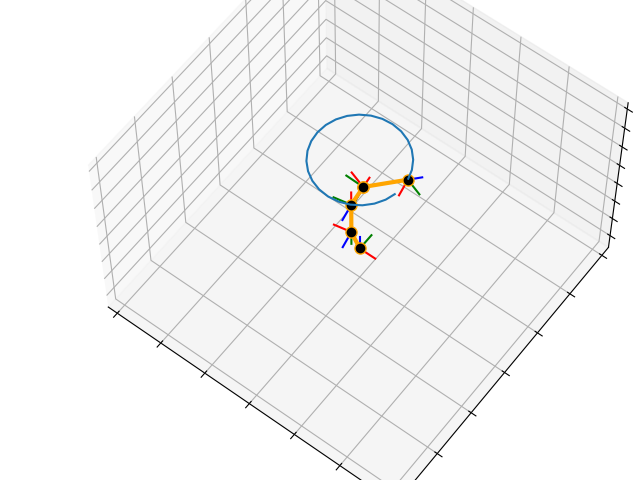

In [17]:
%matplotlib widget

drawer = RobotAnimation(robot=Robot(robot='youbot'))

drawer.draw_trajectory_robot(y_qarr)

Zu den erzeugten Gelenkwinkelstellungen muss noch der TCP generiert werden und dieser muss normalisiert und standardisiert werden.

In [45]:
arr_tcp = datahandler.calc_xyz_euler(y_qarr)
arr_tcp = datahandler.normeuler(arr_tcp)
scaler = StandardScaler()
scaler.fit(arr_tcp)
arr_tcp = scaler.transform(arr_tcp)

traj_pred = mor.predict(arr_tcp)

DH Transformation: 0.01 Sekunden
Euler Winkel: 0.00 Sekunden


Sieht nicht gerade schön aus.

<IPython.core.display.Javascript object>


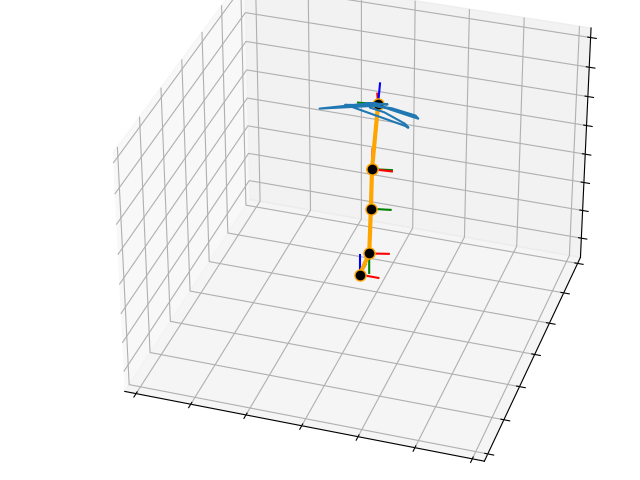

In [46]:
%matplotlib widget

drawer = RobotAnimation(robot=Robot(robot='youbot'))

drawer.draw_trajectory_robot(traj_pred)